# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 2. Load Dataset

In [2]:
file_path = "API_SP.POP.TOTL_DS2_en_csv_v2_38144.csv"
df_raw = pd.read_csv(file_path, skiprows=4)

# 3. Clean and Preprocess

In [3]:
df = df_raw.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 69"], errors='ignore')
df_long = df.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Population")
df_long["Year"] = pd.to_numeric(df_long["Year"], errors='coerce')
df_long = df_long.dropna(subset=["Population"])

# 4. Transform Data

In [4]:
df_latest = df_long[df_long["Year"] == df_long["Year"].max()].copy()
df_latest["Log_Population"] = np.log1p(df_latest["Population"])

# 5. Basic Visualizations

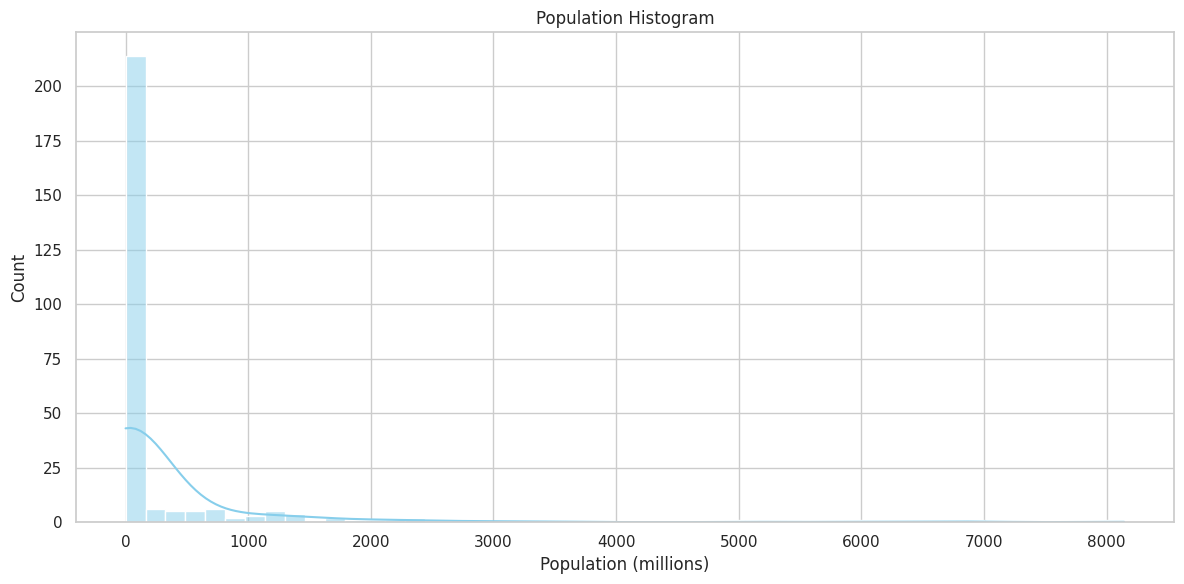

In [5]:
plt.figure()
sns.histplot(df_latest["Population"] / 1e6, bins=50, kde=True, color="skyblue")
plt.title("Population Histogram")
plt.xlabel("Population (millions)")
plt.tight_layout()
plt.show()

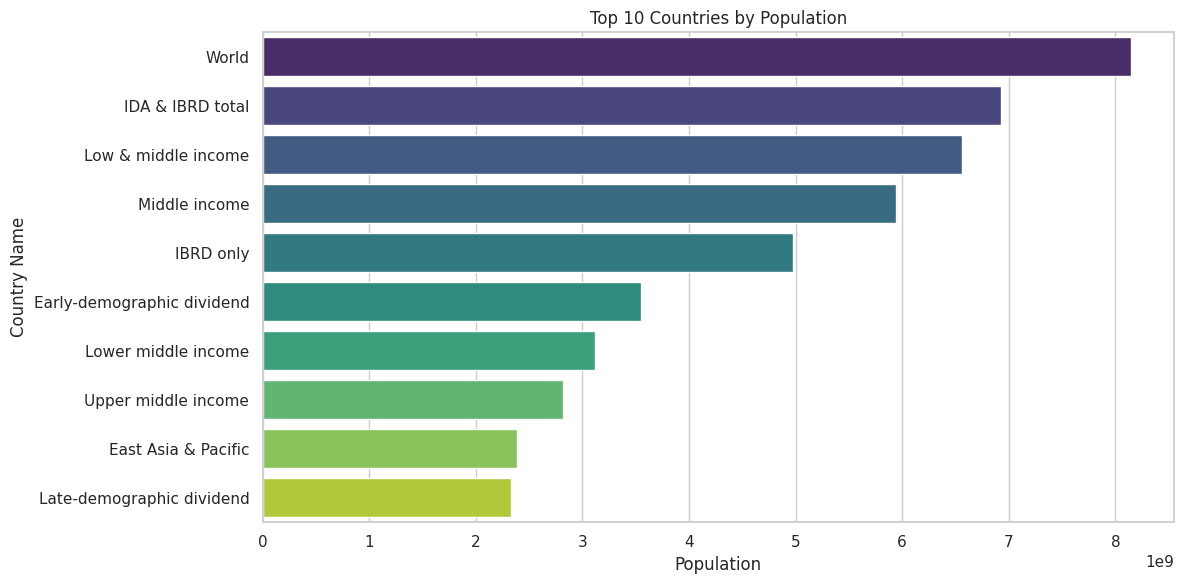

In [6]:
top10 = df_latest.sort_values(by="Population", ascending=False).head(10)
plt.figure()
sns.barplot(data=top10, x="Population", y="Country Name", hue="Country Name", palette="viridis", legend=False)
plt.title("Top 10 Countries by Population")
plt.tight_layout()
plt.show()

# 6. Advanced Distribution Insights

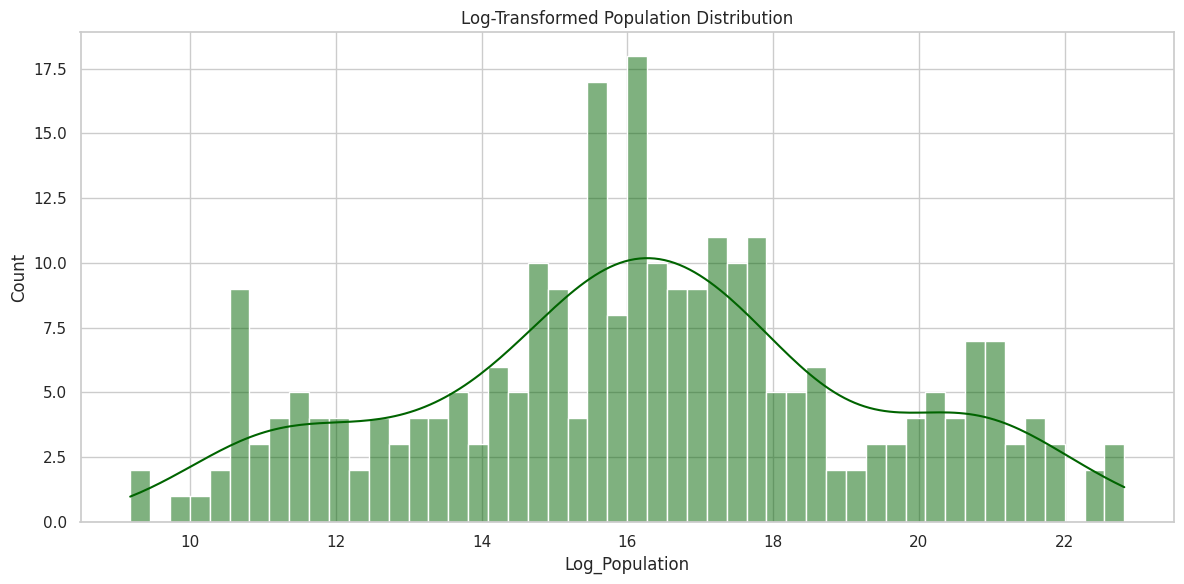

In [7]:
plt.figure()
sns.histplot(df_latest["Log_Population"], bins=50, kde=True, color="darkgreen")
plt.title("Log-Transformed Population Distribution")
plt.tight_layout()
plt.show()

# 7. Outlier Detection

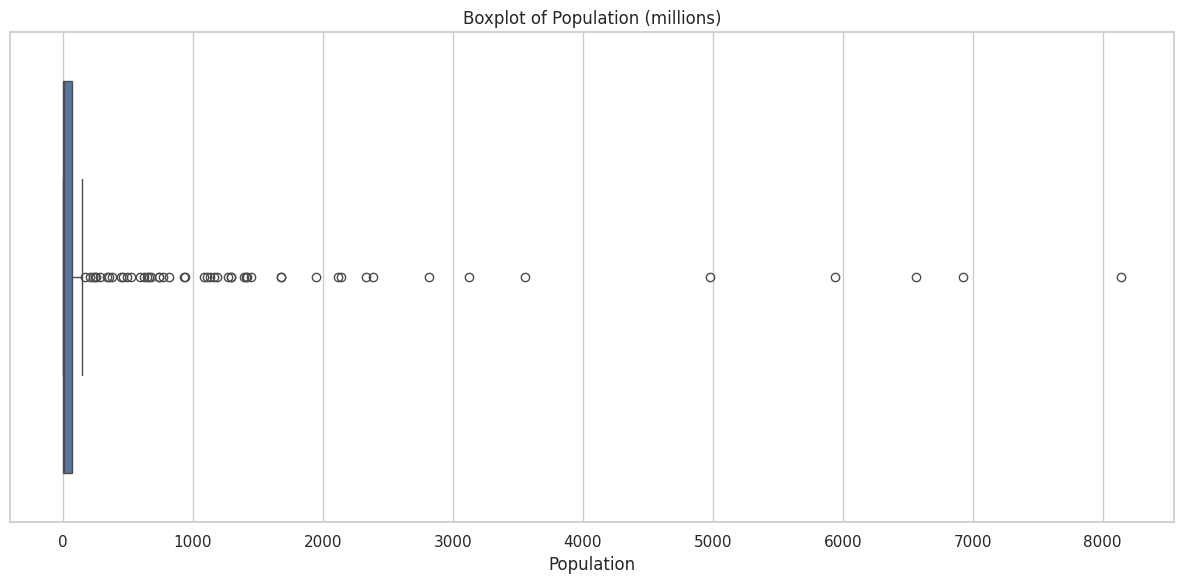

In [8]:
df_latest["Z_Score"] = stats.zscore(df_latest["Population"])
outliers = df_latest[np.abs(df_latest["Z_Score"]) > 2]

plt.figure()
sns.boxplot(x=df_latest["Population"] / 1e6)
plt.title("Boxplot of Population (millions)")
plt.tight_layout()
plt.show()

# 8. Time-Series Analysis

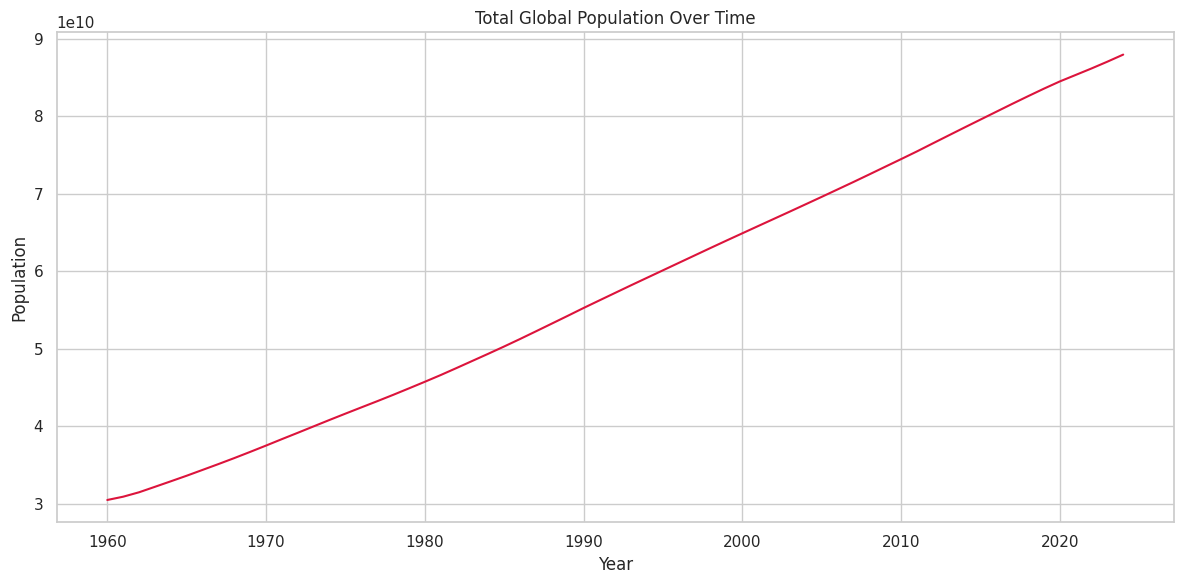

In [9]:
df_total = df_long.groupby("Year")["Population"].sum().reset_index()

plt.figure()
sns.lineplot(data=df_total, x="Year", y="Population", color="crimson")
plt.title("Total Global Population Over Time")
plt.tight_layout()
plt.show()

# 9. Country-wise Trend: Diverse Representation

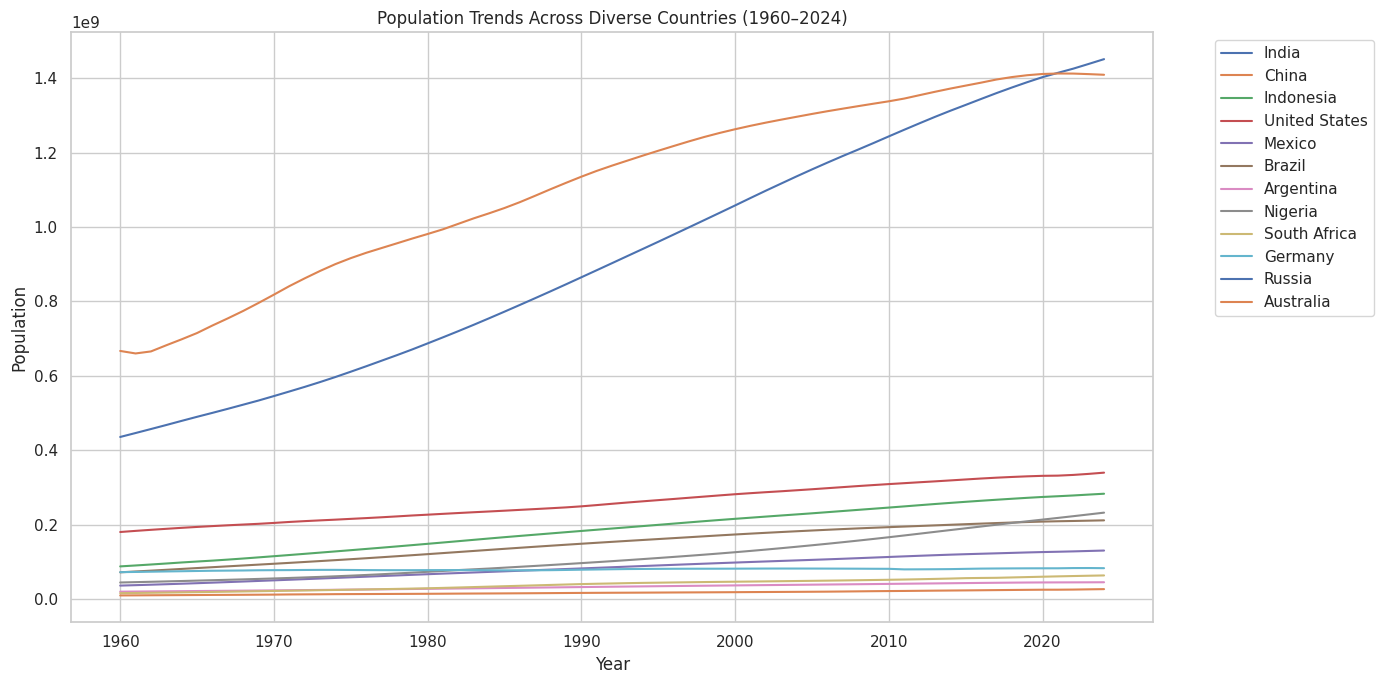

In [10]:
countries = [
    "India", "China", "Indonesia",       # Asia
    "United States", "Mexico",           # North America
    "Brazil", "Argentina",               # South America
    "Nigeria", "South Africa",           # Africa
    "Germany", "Russia",                 # Europe
    "Australia"                          # Oceania
]

plt.figure(figsize=(14, 7))
for c in countries:
    data = df_long[df_long["Country Name"] == c]
    plt.plot(data["Year"], data["Population"], label=c)

plt.title("Population Trends Across Diverse Countries (1960–2024)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 10. Categorical Comparison (Simulated Continent Mapping)

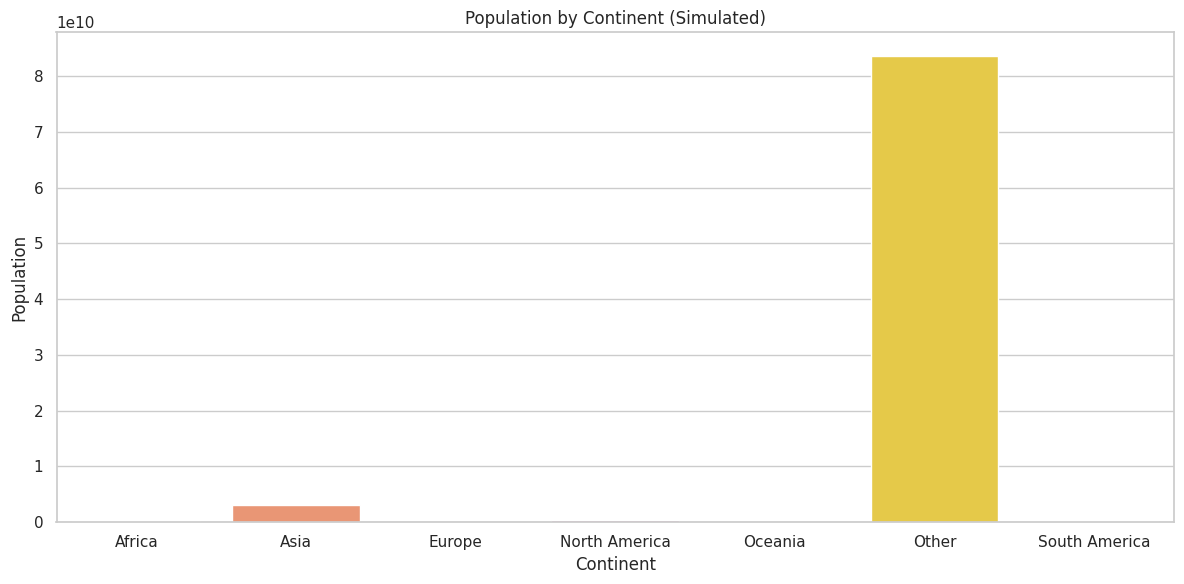

In [11]:
continent_map = {
    "India": "Asia", "China": "Asia", "Indonesia": "Asia",
    "United States": "North America", "Mexico": "North America",
    "Brazil": "South America", "Argentina": "South America",
    "Nigeria": "Africa", "South Africa": "Africa",
    "Germany": "Europe", "Russia": "Europe",
    "Australia": "Oceania"
}
df_latest["Continent"] = df_latest["Country Name"].map(continent_map).fillna("Other")
continent_group = df_latest.groupby("Continent")["Population"].sum().reset_index()

plt.figure()
sns.barplot(data=continent_group, x="Continent", y="Population", hue="Continent", palette="Set2", legend=False)
plt.title("Population by Continent (Simulated)")
plt.tight_layout()
plt.show()

# 11. Statistical Summary

In [12]:
desc = df_latest["Population"].describe()
skew = df_latest["Population"].skew()

def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(sorted_x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

gini = gini_coefficient(df_latest["Population"].values)

# 12. Clustering Countries by Population History

/tmp/ipython-input-13-699148654.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cluster = df_long.pivot(index="Country Name", columns="Year", values="Population").fillna(method='ffill', axis=1).dropna()


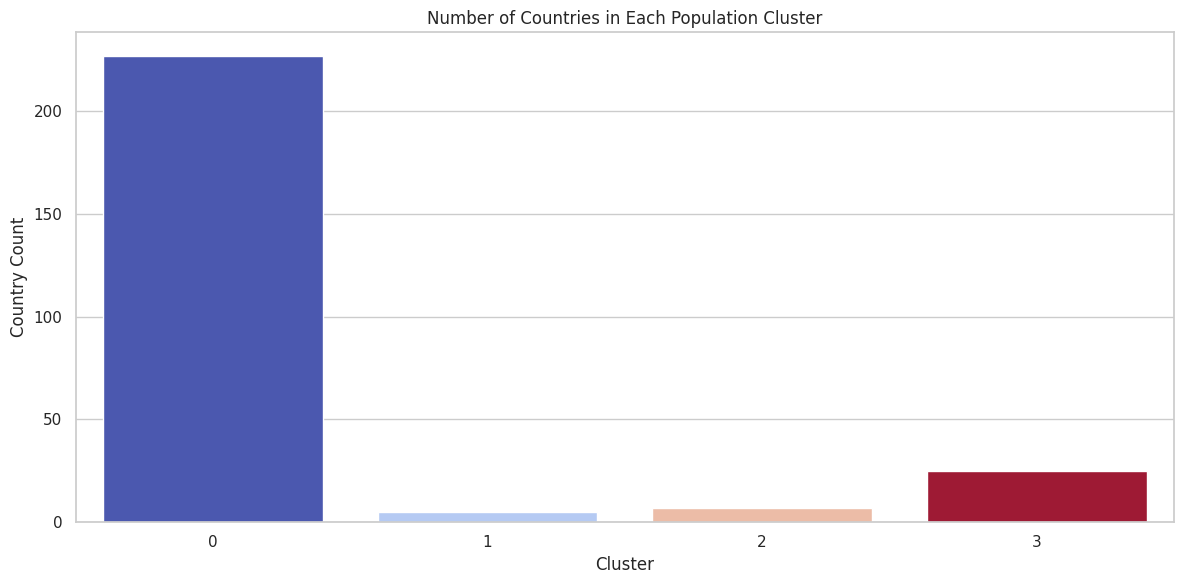

In [13]:
df_cluster = df_long.pivot(index="Country Name", columns="Year", values="Population").fillna(method='ffill', axis=1).dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)

kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster["Cluster"] = kmeans.fit_predict(scaled_data)

cluster_sizes = df_cluster["Cluster"].value_counts().sort_index()
plt.figure()
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, hue=cluster_sizes.index, palette="coolwarm", legend=False)
plt.title("Number of Countries in Each Population Cluster")
plt.xlabel("Cluster")
plt.ylabel("Country Count")
plt.tight_layout()
plt.show()